In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [17]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(init_bouncing_ball, init_proposal)

In [18]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(bouncing_ball_step, step_proposal)

In [19]:
def training_model():
    return foldable.Reduce(foldable.Foldable(training_step(), initializer=training_initializer()), lambda: range(T))

02/15/2019 17:59:57 ELBO=-6.12105469e+02 at epoch 1
02/15/2019 17:59:58 ELBO=-5.79946045e+02 at epoch 2
02/15/2019 17:59:59 ELBO=-5.71699158e+02 at epoch 3
02/15/2019 18:00:01 ELBO=-6.82183228e+02 at epoch 4
02/15/2019 18:00:02 ELBO=-6.30834167e+02 at epoch 5
02/15/2019 18:00:03 ELBO=-6.58313660e+02 at epoch 6
02/15/2019 18:00:04 ELBO=-6.07637207e+02 at epoch 7
02/15/2019 18:00:06 ELBO=-5.03762848e+02 at epoch 8
02/15/2019 18:00:07 ELBO=-6.54769653e+02 at epoch 9
02/15/2019 18:00:09 ELBO=-6.14858276e+02 at epoch 10
02/15/2019 18:00:10 ELBO=-5.80934753e+02 at epoch 11
02/15/2019 18:00:12 ELBO=-5.35694031e+02 at epoch 12
02/15/2019 18:00:13 ELBO=-6.03671021e+02 at epoch 13
02/15/2019 18:00:14 ELBO=-5.65277710e+02 at epoch 14
02/15/2019 18:00:16 ELBO=-5.76189453e+02 at epoch 15
02/15/2019 18:00:17 ELBO=-6.15001831e+02 at epoch 16
02/15/2019 18:00:18 ELBO=-5.85706848e+02 at epoch 17
02/15/2019 18:00:20 ELBO=-5.81050964e+02 at epoch 18
02/15/2019 18:00:21 ELBO=-5.69969604e+02 at epoch 19
02

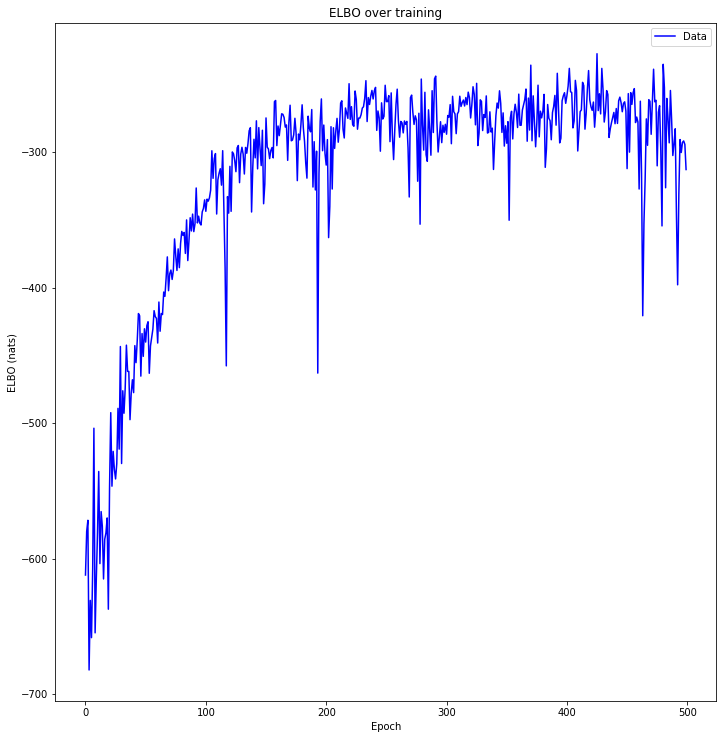

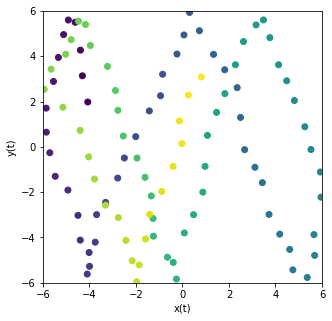

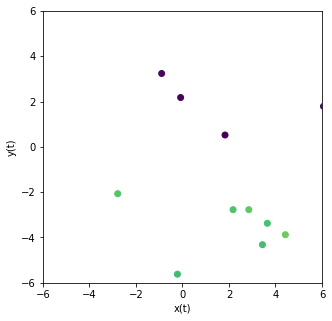

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.generalized_rmsmc(importance_sampler)
    (dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [21]:
trained_params

"{'dynamics__loc': 'tensor([[ 0.1639, -0.5975],\n        [ 0.1820, -0.0327]], grad_fn=<CloneBackward>)', 'dynamics__scale': 'tensor([[-1.3816, -0.7878],\n        [-3.3056, -2.9117]], grad_fn=<CloneBackward>)', 'noise__loc': 'tensor([[-0.9658, -0.3787],\n        [ 0.1144, -0.5464]], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([[-2.7653,  1.1261],\n        [-2.9113, -2.5815]], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.0233,  0.0000],\n        [ 0.4520, -0.8942]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-4.0746,  2.5210], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([[-0.5034, -0.1079],\n        [-0.0514,  0.0620]], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([[-1.9256,  0.7836],\n        [-2.0304, -2.7346]], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-0.4425,  0.5971],\n        [-0.1754,  1.1230],\n        [-0.3399,  1.1013],\n        [-0.2067,  0.1426],\n        [-0.4111, -0.7409],\n        [-0.1531

In [22]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-4.0717,  1.9820])
Position at time 1 tensor([-4.3038,  3.1388])
Position at time 2 tensor([-4.3869,  4.2711])
Position at time 3 tensor([-4.6140,  5.5025])
Position at time 4 tensor([-4.9077,  5.6018])
Position at time 5 tensor([-5.1105,  4.9586])
Position at time 6 tensor([-5.3360,  3.9511])
Position at time 7 tensor([-5.5470,  2.8897])
Position at time 8 tensor([-5.8614,  1.7108])
Position at time 9 tensor([-5.8550,  0.6514])
Position at time 10 tensor([-5.7053, -0.2581])
Position at time 11 tensor([-5.4721, -1.2986])
Position at time 12 tensor([-4.9262, -1.9061])
Position at time 13 tensor([-4.4925, -3.0226])
Position at time 14 tensor([-4.3950, -4.1168])
Position at time 15 tensor([-4.0147, -4.6626])
Position at time 16 tensor([-4.0963, -5.6134])
Position at time 17 tensor([-3.9969, -5.2724])
Position at time 18 tensor([-3.7509, -4.2069])
Position at time 19 tensor([-3.6932, -2.9901])
Position at time 20 tensor([-3.3071, -2.4487])
Position at time 21 ten

In [23]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([1.8313, 0.5252])
Inferred position at time 1 tensor([-0.0777,  2.1797])
Inferred position at time 2 tensor([-0.8942,  3.2414])
Inferred position at time 3 tensor([6.0660, 1.7907])
Inferred position at time 4 tensor([13.4675, -0.5196])
Inferred position at time 5 tensor([23.7154, -2.7634])
Inferred position at time 6 tensor([23.9856, -4.1596])
Inferred position at time 7 tensor([33.1147, -5.8987])
Inferred position at time 8 tensor([31.4450, -7.0648])
Inferred position at time 9 tensor([44.3750, -8.0930])
Inferred position at time 10 tensor([43.8450, -8.6992])
Inferred position at time 11 tensor([54.0080, -8.8474])
Inferred position at time 12 tensor([61.3306, -8.8012])
Inferred position at time 13 tensor([67.3440, -8.7409])
Inferred position at time 14 tensor([69.7305, -8.1060])
Inferred position at time 15 tensor([71.1114, -6.6535])
Inferred position at time 16 tensor([70.7642, -7.3638])
Inferred position at time 17 tensor([81.3316, -4.7623])
Inferr

In [24]:
bouncing_ball_smc = importance_sampler.walk(importance.ImportanceResampler)
(dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-4.0558,  2.7515])
Inferred position at time 1 tensor([-3.9980,  3.3995])
Inferred position at time 2 tensor([-4.0716,  4.1794])
Inferred position at time 3 tensor([-4.4738,  4.9595])
Inferred position at time 4 tensor([-4.7079,  4.7613])
Inferred position at time 5 tensor([-4.9549,  3.8484])
Inferred position at time 6 tensor([-5.1171,  3.0193])
Inferred position at time 7 tensor([-5.3862,  1.8715])
Inferred position at time 8 tensor([-5.7282,  0.7033])
Inferred position at time 9 tensor([-5.5085, -0.3699])
Inferred position at time 10 tensor([-4.7031, -1.0188])
Inferred position at time 11 tensor([-4.1369, -1.8830])
Inferred position at time 12 tensor([-3.4993, -2.5416])
Inferred position at time 13 tensor([-2.7475, -3.5232])
Inferred position at time 14 tensor([-2.5168, -4.1046])
Inferred position at time 15 tensor([-1.8043, -4.5730])
Inferred position at time 16 tensor([-1.5605, -5.4853])
Inferred position at time 17 tensor([-0.7261, -4.9191])
In

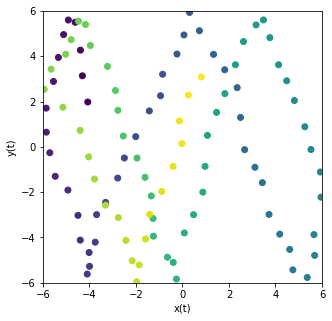

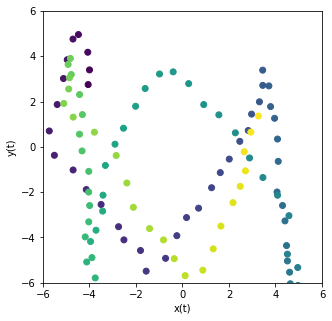

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)

In [27]:
bouncing_ball_smc = mcmc.generalized_rmsmc(importance_sampler, 5)
(dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [28]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([0.6393, 0.4892])
Inferred position at time 1 tensor([-2.1037,  2.1677])
Inferred position at time 2 tensor([-0.9040,  1.6678])
Inferred position at time 3 tensor([0.0569, 2.1761])
Inferred position at time 4 tensor([2.1533, 0.1031])
Inferred position at time 5 tensor([ 4.2033, -2.1681])
Inferred position at time 6 tensor([ 5.8810, -4.2398])
Inferred position at time 7 tensor([ 6.4696, -5.7033])
Inferred position at time 8 tensor([ 6.6669, -7.0143])
Inferred position at time 9 tensor([ 7.2934, -7.8256])
Inferred position at time 10 tensor([ 7.4035, -7.9897])
Inferred position at time 11 tensor([ 8.1414, -8.6490])
Inferred position at time 12 tensor([ 8.2442, -8.6606])
Inferred position at time 13 tensor([ 8.7602, -8.9912])
Inferred position at time 14 tensor([ 8.9054, -9.3021])
Inferred position at time 15 tensor([ 9.4748, -8.8835])
Inferred position at time 16 tensor([ 9.0702, -9.2315])
Inferred position at time 17 tensor([ 8.8521, -8.1004])
Inferred

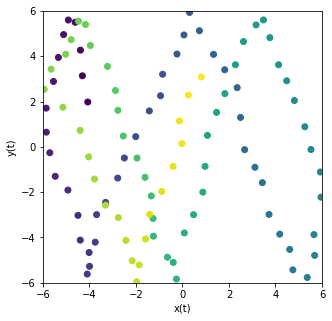

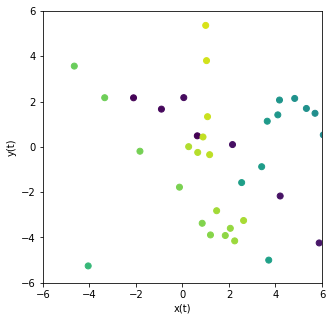

In [29]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)